In [93]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

In [94]:
function getcsv(url)
    df = readtable(Requests.get_streaming(url))
end
function csvtotimearray(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[2:end])
    TimeArray(timestamp,dataarray,colnames[2:end])
end
function yahoo(symbol, startdate)
    str="a=$(Dates.month(startdate)-1)"*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/$symbol.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=$str"
    csvtotimearray(url)
end

quandl (generic function with 1 method)

In [95]:
startdate=Date(2007,11,1) # set an early date to make use of all CBOE/GVZ data
symbol="QQQ"
ohlcv=yahoo(symbol, startdate)

2148x6 TimeSeries.TimeArray{Real,2,DataType} 2007-11-01 to 2016-05-13

             Open      High      Low       Close     Volume          Adj_Close  
2007-11-01 | 54.68     54.77     53.97     54.0      181974200       49.7983    
2007-11-02 | 54.42     54.55     53.6      54.42     217882900       50.1856    
2007-11-05 | 53.86     54.4      53.59     54.07     150588900       49.8629    
2007-11-06 | 54.33     54.69     53.78     54.68     131884700       50.4254    
⋮
2016-05-10 | 106.26    107.38    106.07    107.33    21013500        107.33     
2016-05-11 | 107.17    107.49    106.33    106.36    20883000        106.36     
2016-05-12 | 106.61    106.74    105.14    105.89    29120600        105.89     
2016-05-13 | 105.85    106.45    105.29    105.5     21036800        105.5      


In [96]:
vix=quandl("CBOE/VIX", startdate)
vixarray=TimeArray(vix.timestamp,vix.values[:,end],["CBOE/VIX"])

2147x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-11-01 to 2016-05-12

             CBOE/VIX  
2007-11-01 | 23.21     
2007-11-02 | 23.01     
2007-11-05 | 24.31     
2007-11-06 | 21.39     
⋮
2016-05-09 | 14.57     
2016-05-10 | 13.63     
2016-05-11 | 14.69     
2016-05-12 | 14.41     


In [97]:
vxn=quandl("CBOE/VXN", startdate)
vxnarray=TimeArray(vxn.timestamp,vxn.values[:,end],["CBOE/VXN"])

2147x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-11-01 to 2016-05-12

             CBOE/VXN  
2007-11-01 | 26.26     
2007-11-02 | 24.83     
2007-11-05 | 26.1      
2007-11-06 | 23.91     
⋮
2016-05-09 | 17.38     
2016-05-10 | 16.27     
2016-05-11 | 17.16     
2016-05-12 | 17.26     


In [98]:
ovx=quandl("CBOE/OVX", startdate) # CBOE/OVX since 2007-05-10
ovxarray=TimeArray(ovx.timestamp,ovx.values,["CBOE/OVX"])

2148x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-12

             CBOE/OVX  
2007-11-01 | 39.71     
2007-11-02 | 39.99     
2007-11-05 | 40.14     
2007-11-06 | 41.2      
⋮
2016-05-09 | 44.14     
2016-05-10 | 42.28     
2016-05-11 | 42.02     
2016-05-12 | 41.5      


In [99]:
evz=quandl("CBOE/EVZ", startdate) # CBOE/EVZ since 2007-11-01
evzarray=TimeArray(evz.timestamp,evz.values,["CBOE/EVZ"])

2140x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-12

             CBOE/EVZ  
2007-11-01 | 8.09      
2007-11-02 | 8.12      
2007-11-05 | 7.98      
2007-11-06 | 8.18      
⋮
2016-05-09 | 9.41      
2016-05-10 | 9.22      
2016-05-11 | 9.01      
2016-05-12 | 9.07      


In [100]:
gvz=quandl("CBOE/GVZ", startdate) # CBOE/GVZ since 2008-6-3
gvzarray=TimeArray(gvz.timestamp,gvz.values,["CBOE/GVZ"])

2002x1 TimeSeries.TimeArray{Float64,2,DataType} 2008-06-03 to 2016-05-12

             CBOE/GVZ  
2008-06-03 | 22.89     
2008-06-04 | 22.69     
2008-06-05 | 22.78     
2008-06-06 | 23.6      
⋮
2016-05-09 | 18.65     
2016-05-10 | 18.04     
2016-05-11 | 18.35     
2016-05-12 | 17.84     


In [101]:
eurusd=quandl("ECB/EURUSD", startdate)
eurusdarray=TimeArray(eurusd.timestamp,eurusd.values,["ECB/EURUSD"])

2183x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-13

             ECB/EURUSD  
2007-11-01 | 1.4423      
2007-11-02 | 1.4479      
2007-11-05 | 1.4488      
2007-11-06 | 1.4547      
⋮
2016-05-10 | 1.1375      
2016-05-11 | 1.1409      
2016-05-12 | 1.1389      
2016-05-13 | 1.1348      


In [140]:
oil=quandl("OPEC/ORB", startdate)
oilarray=TimeArray(oil.timestamp,oil.values,["OPEC/ORB"])

2201x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-12

             OPEC/ORB  
2007-11-01 | 87.47     
2007-11-02 | 87.47     
2007-11-05 | 88.0      
2007-11-06 | 89.02     
⋮
2016-05-09 | 40.76     
2016-05-10 | 40.2      
2016-05-11 | 41.4      
2016-05-12 | 43.31     


In [141]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
goldarray=TimeArray(gold.timestamp,gold.values./gold.values[1],["WGC/GOLD_DAILY_USD"])

2227x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-13

             WGC/GOLD_DAILY_USD  
2007-11-01 | 1.0                 
2007-11-02 | 1.0079              
2007-11-05 | 1.0184              
2007-11-06 | 1.0408              
⋮
2016-05-10 | 1.598               
2016-05-11 | 1.6158              
2016-05-12 | 1.6189              
2016-05-13 | 1.6019              


In [142]:
aaii_weekly=quandl("AAII/AAII_SENTIMENT", startdate)

446x12 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-12

             Bullish  Neutral  Bearish  Total   Bullish_8_Week_Mov_Avg  Bull_Bear_Spread  Bullish_Average  Bullish_Average_St_Dev  Bullish_Average_St_Dev_1  S_P_500_Weekly_High  S_P_500_Weekly_Low  S_P_500_Weekly_Close  
2007-11-01 | 0.4471   0.1882   0.3647   1.0     0.4412                  0.0824            0.3854           0.4886                  0.2822                    1551.91              1529.42             1549.38               
2007-11-08 | 0.3619   0.1238   0.5143   1.0     0.4365                  -0.1524           0.3854           0.4886                  0.2822                    1519.49              1475.08             1475.62               
2007-11-15 | 0.3301   0.1748   0.4951   1.0     0.4287                  -0.165            0.3854           0.4886                  0.2822                    1491.51              1466.99             1470.58               
2007-11-22 | 0.2558   0.2171   0.5271   1.

In [143]:
ustreasury=quandl("USTREASURY/REALLONGTERM", startdate)
ustreasuryarray=TimeArray(ustreasury.timestamp,ustreasury.values,["USTREASURY/REALLONGTERM"])

2135x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-13

             USTREASURY/REALLONGTERM  
2007-11-01 | 2.12                     
2007-11-02 | 2.05                     
2007-11-05 | 2.06                     
2007-11-06 | 2.07                     
⋮
2016-05-10 | 0.63                     
2016-05-11 | 0.62                     
2016-05-12 | 0.63                     
2016-05-13 | 0.6                      


In [144]:
ushybond=quandl("ML/HYOAS", startdate)

2224x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-10

             VALUE    
2007-11-01 | 4.53     
2007-11-02 | 4.65     
2007-11-05 | 4.69     
2007-11-06 | 4.66     
⋮
2016-05-05 | 6.42     
2016-05-06 | 6.48     
2016-05-09 | 6.53     
2016-05-10 | 6.46     


In [145]:
usaabond=quandl("ML/AAOAS", startdate)

2224x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-10

             VALUE   
2007-11-01 | 1.29    
2007-11-02 | 1.34    
2007-11-05 | 1.41    
2007-11-06 | 1.42    
⋮
2016-05-05 | 0.86    
2016-05-06 | 0.87    
2016-05-09 | 0.87    
2016-05-10 | 0.88    


In [146]:
ta=ohlcv["Close"];
predictcount=252;
rangelength=35;

In [147]:
function padseries(short, long)
    last=short.timestamp[end]
    idx=searchsortedfirst(long.timestamp,last)
    times=long.timestamp[idx+1:end]
    n=length(times)
    values=zeros(n)
    for i=1:n
        values[i]=short.values[end]
    end
    TimeArray([short.timestamp;times],[short.values;values],short.colnames)
end

padseries (generic function with 1 method)

In [148]:
ushybond=padseries(ushybond, gold)
usaabond=padseries(usaabond, gold)
ushybondarray=TimeArray(ushybond.timestamp,ushybond.values,["ML/HYOAS"])
usaabondarray=TimeArray(usaabond.timestamp,usaabond.values,["ML/AAOAS"])
usyieldspread=ushybondarray.-usaabondarray;
usyieldspreadarray=TimeArray(usyieldspread.timestamp,usyieldspread.values,["ML/HYOAS-ML/AAOAS"]);

In [149]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end
function merge2(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

merge2 (generic function with 1 method)

In [150]:
function weekly_to_daily(weekly, daily)
    width=length(weekly.colnames)
    merged=merge2(weekly,daily)
    series=daily[merged.timestamp[1]:merged.timestamp[end]]
    sentiment=zeros(length(series),length(merged.colnames))
    for i in merged.timestamp
        idx1=searchsortedfirst(series.timestamp,i)
        idx2=searchsortedfirst(merged.timestamp,i)
        sentiment[idx1,:]=merged.values[idx2,:]
    end
#     for i=2:length(merged.timestamp)
#         i1=merged.timestamp[i-1]
#         i2=merged.timestamp[i]
#         idx1=searchsortedfirst(series.timestamp,i1)
#         idx2=searchsortedfirst(series.timestamp,i2)
#         span=idx2-idx1
#         d=1/span
#         ds=collect(linspace(d,1-d,span-1))
#         for i=1:length(ds)
#             alpha=ds[i]
#             sentiment[idx1+i,:]=(1-alpha).*sentiment[idx1,:].+alpha.*sentiment[idx2,:]
#         end
#     end
#     last=searchsortedfirst(series.timestamp,merged.timestamp[end])
    last=1
    for i=last+1:size(sentiment,1)
        if sentiment[i,1]==0
            sentiment[i,:]=sentiment[i-1,:]
        end
    end
    TimeArray(series.timestamp,sentiment[:,1:width],merged.colnames[1:width])
end
function aaii_to_daily(weekly, daily)
    interpolated=weekly_to_daily(weekly, daily);
    TimeArray(interpolated.timestamp,interpolated.values[:,5:6],["AAII/Bullish_8_Week_Mov_Avg","AAII/Bull_Bear_Spread"]);
end

aaii_to_daily (generic function with 1 method)

In [151]:
function aroon(ta, n=25)
    up=moving(ta,x->findlast(x,maximum(x))/length(x),n)
    down=moving(ta,x->findlast(x,minimum(x))/length(x),n)
    d=up.-down
    r=merge2(up,down)
    r=merge2(r,d)
    TimeArray(r.timestamp,r.values,["aroon$n.up","aroon$n.down","aroon$n.up-down"])
end

aroon (generic function with 2 methods)

In [152]:
function volumeoscillator(ohlcv, n=28, c="Volume")
    volume=ohlcv[c]
    vshort=ema(volume, int(n/2))
    vlong=ema(volume, n)
    volumeoscillator=(vshort.-vlong)./vlong
    TimeArray(volumeoscillator.timestamp,volumeoscillator.values,["VolumeOscillator$n"])
end

volumeoscillator (generic function with 3 methods)

In [153]:
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf$n"], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [154]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=merge2(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev$n,$width", "bbstd$n,$width"])
end
function bollingerbands_all(ta, n=20, width=2)
#     b0=bollingerbands_deviation(ta, int(n/2), width)
    b1=bollingerbands_deviation(ta, n, width)
    b2=bollingerbands_deviation(ta, n*2, width)
#     r=merge2(b0,b1)
    merge2(b1,b2)
end

bollingerbands_all (generic function with 3 methods)

In [155]:
function vwap_divergence(ohlcv, n=28)
    v1=vwap(ohlcv, int(n/2))
    v2=vwap(ohlcv, n)
    v3=vwap(ohlcv, n*2)
    v4=vwap(ohlcv, n*4)
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["vwap$(int(n/2))","vwap$n","vwap$(n*2)","vwap$(n*4)","vwap$(int(n/2))-$n","vwap$n-$(n*2)","vwap$(n*2)-$(n*4)"]#,"vwap$(n*8)","vwap$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

vwap_divergence (generic function with 2 methods)

In [156]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr$n"], ohlc.meta)
end
function atr_divergence(ohlcv, n=28)
    v1=averagetruerange(ohlcv,int(n/2));
    v2=averagetruerange(ohlcv,n);
    v3=averagetruerange(ohlcv,n*2);
    v4=averagetruerange(ohlcv,n*4);
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["atr$(int(n/2))","atr$n","atr$(n*2)","atr$(n*4)","atr$(int(n/2))-$n","atr$n-$(n*2)","atr$(n*2)-$(n*4)"]#,"atr$(n*8)","atr$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

atr_divergence (generic function with 2 methods)

In [157]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pv=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nv=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pv,sum,n)
    nsum=moving(nv,sum,n)
    re=psum./(psum.+nsum)
    TimeArray(re.timestamp, re.values, ["mfi$n"], ohlcv.meta)
end
function rsi_mfi_divergence(rsi, mfi, n=14)
    signal=ema(mfi.-rsi,5)
    TimeArray(signal.timestamp,signal.values,["rsi_mfi_divergence"])
end
function rsi_mfi_all(ohlcv, n=28, c="Close")
    ta=ohlcv[c]
    r1=rsi(ta,n)./100
    m1=moneyflowindex(ohlcv,n)
    merge2(r1,m1)
end

rsi_mfi_all (generic function with 3 methods)

In [158]:
function ChandeMomentumOscillator(ohlcv, n=9, h="High", l="Low", c="Close")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pv=TimeArray(diff.timestamp,positive,["Positive"])
    nv=TimeArray(diff.timestamp,negative,["Negative"])
    psum=moving(pv,sum,n)
    nsum=moving(nv,sum,n)
    re=(psum.-nsum)./(psum.+nsum)
    TimeArray(re.timestamp, re.values, ["cmo$n"], ohlcv.meta)
end
function MoneyFlowOscillator(ohlcv, n=9, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pv=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nv=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pv,sum,n)
    nsum=moving(nv,sum,n)
    re=(psum.-nsum)./(psum.+nsum)
    TimeArray(re.timestamp, re.values, ["mf$n"], ohlcv.meta)
end
function MoneyFlowDivergence(ohlcv, n=9, h="High", l="Low", c="Close", v="Volume")
    cmo=ChandeMomentumOscillator(ohlcv, n)
    mfo=MoneyFlowOscillator(ohlcv, n)
    diff=mfo.-cmo
    TimeArray(diff.timestamp,diff.values,["mfd$n"])
end
function mfo_all(ohlcv, n=9, signal=7, h="High", l="Low", c="Close", v="Volume")
    mf1=MoneyFlowDivergence(ohlcv, int(n/2))
    mf2=MoneyFlowDivergence(ohlcv, n)
    d1=mf1.-mf2
    re=ema(d1, signal)
    TimeArray(re.timestamp,re.values,["mfo$n"])
end

mfo_all (generic function with 7 methods)

In [159]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    r = merge(mcd, sig, col_names=["macd($fast,$slow,$signal)", "signal"])
#     merge(r, mcd .- sig, col_names=[r.colnames; ["histogram"]])
end

macd2 (generic function with 4 methods)

In [160]:
function priceindex(ta, n=28)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=merge2(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["priceindex$n"]])
end

priceindex (generic function with 2 methods)

In [161]:
aaiiarray=aaii_to_daily(aaii_weekly, gold);
rsimfiarray=rsi_mfi_all(ohlcv,rangelength);
macdarray=macd2(ta,int(rangelength/2),rangelength);
vwaparray=vwap_divergence(ohlcv,rangelength);
atrarray=atr_divergence(ohlcv,rangelength);
aroonarray=aroon(ta,rangelength);
volumeoscillatorarray=volumeoscillator(ohlcv,rangelength);
cmfarray=chaikinmoneyflow(ohlcv,rangelength);
bbarray=bollingerbands_all(ta,rangelength,2);
# mfoarray=mfo_all(ohlcv, int(rangelength/2));
priceindexarray=priceindex(ta,rangelength);

 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in vwap_divergence(::TimeSeries.TimeArray{Real,2,DataType}, ::Int64) at ./In[155]:2
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from ./dict.jl:779
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/IJulia.jl:141
 in (::IJulia.##24#30)() at ./task.jl:308
while loading In[161], in expression starting on line 4
 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in vwap_divergence(::TimeSeries.TimeArray{Real,2,DataType}, ::Int64) at ./In[155]:15
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading

In [162]:
featurearray=merge2(bbarray,cmfarray);
# featurearray=merge2(featurearray,mfoarray);
featurearray=merge2(featurearray,macdarray);
featurearray=merge2(featurearray,volumeoscillatorarray);
featurearray=merge2(featurearray,rsimfiarray);
featurearray=merge2(featurearray,atrarray);
featurearray=merge2(featurearray,vwaparray);
featurearray=merge2(featurearray,aroonarray);
featurearray=merge2(featurearray,ustreasuryarray);
featurearray=merge2(featurearray,ushybondarray);
featurearray=merge2(featurearray,usaabondarray);
featurearray=merge2(featurearray,usyieldspreadarray);
featurearray=merge2(featurearray,vixarray);
featurearray=merge2(featurearray,vxnarray);
featurearray=merge2(featurearray,goldarray);
featurearray=merge2(featurearray,gvzarray);
featurearray=merge2(featurearray,oilarray);
featurearray=merge2(featurearray,ovxarray);
featurearray=merge2(featurearray,eurusdarray);
featurearray=merge2(featurearray,evzarray);
featurearray=merge2(featurearray,aaiiarray);

 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in volumeoscillator(::TimeSeries.TimeArray{Real,2,DataType}, ::Int64, ::ASCIIString) at ./In[152]:3
 in volumeoscillator(::TimeSeries.TimeArray{Real,2,DataType}, ::Int64) at ./In[152]:2
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from ./dict.jl:779
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/IJulia.jl:141
 in (::IJulia.##24#30)() at ./task.jl:308
while loading In[161], in expression starting on line 7


In [163]:
withlabel=merge2(featurearray,priceindexarray)

1933x45 TimeSeries.TimeArray{Real,2,DataType} 2008-06-03 to 2016-03-24

             bbdev35,2  bbstd35,2  bbdev70,2  bbstd70,2  cmf35   macd(18,35,9)  signal  VolumeOscillator35  rsi     mfi35   atr18   atr35   atr70   atr140  atr18-35  atr35-70  atr70-140  vwap18    vwap35    vwap70    vwap140   vwap18-35  vwap35-70  vwap70-140  aroon35.up  aroon35.down  aroon35.up-down  USTREASURY/REALLONGTERM  ML/HYOAS  ML/AAOAS  ML/HYOAS-ML/AAOAS  CBOE/VIX  CBOE/VXN  WGC/GOLD_DAILY_USD  CBOE/GVZ  OPEC/ORB  CBOE/OVX  ECB/EURUSD  CBOE/EVZ  AAII/Bullish_8_Week_Mov_Avg  AAII/Bull_Bear_Spread  Close     min       max       priceindex35  
2008-06-03 | 0.3459     1.4082     0.6161     2.569      0.1688  0.7989         0.8637  0.0099              0.564   0.6702  0.8993  0.9583  1.0337  1.0819  -0.0589   -0.0754   -0.0483    49.1149   48.1934   45.649    46.7377   0.9215     2.5444     -1.0887     0.9429      0.0286        0.9143           2.12                     6.78      2.09      4.69               20.

In [164]:
withoutlabel=merge2(featurearray,ta)

1966x42 TimeSeries.TimeArray{Real,2,DataType} 2008-06-03 to 2016-05-12

             bbdev35,2  bbstd35,2  bbdev70,2  bbstd70,2  cmf35   macd(18,35,9)  signal  VolumeOscillator35  rsi     mfi35   atr18   atr35   atr70   atr140  atr18-35  atr35-70  atr70-140  vwap18    vwap35    vwap70    vwap140   vwap18-35  vwap35-70  vwap70-140  aroon35.up  aroon35.down  aroon35.up-down  USTREASURY/REALLONGTERM  ML/HYOAS  ML/AAOAS  ML/HYOAS-ML/AAOAS  CBOE/VIX  CBOE/VXN  WGC/GOLD_DAILY_USD  CBOE/GVZ  OPEC/ORB  CBOE/OVX  ECB/EURUSD  CBOE/EVZ  AAII/Bullish_8_Week_Mov_Avg  AAII/Bull_Bear_Spread  Close     
2008-06-03 | 0.3459     1.4082     0.6161     2.569      0.1688  0.7989         0.8637  0.0099              0.564   0.6702  0.8993  0.9583  1.0337  1.0819  -0.0589   -0.0754   -0.0483    49.1149   48.1934   45.649    46.7377   0.9215     2.5444     -1.0887     0.9429      0.0286        0.9143           2.12                     6.78      2.09      4.69               20.24     23.89     1.1126           

In [165]:
dataoffset=length(withoutlabel)-length(withlabel)
lastdate=withlabel.timestamp[end]
lastdateidx=searchsortedfirst(withoutlabel.timestamp, lastdate)
splitidx=lastdateidx-predictcount+dataoffset
newfeatures=TimeArray(withoutlabel.timestamp[splitidx+1:end],withoutlabel.values[splitidx+1:end,:],withoutlabel.colnames);

In [166]:
training=TimeArray(withlabel.timestamp[1:splitidx],withlabel.values[1:splitidx,:],withlabel.colnames);

In [167]:
test=TimeArray(withlabel.timestamp[splitidx+1:end],withlabel.values[splitidx+1:end,:],withlabel.colnames);

In [168]:
rsiidx=findfirst(withlabel.colnames,"rsi")
mfiidx=findfirst(withlabel.colnames,"mfi$rangelength")
bbsidx=findfirst(withlabel.colnames,"AAII/Bull_Bear_Spread")
pricerangeidx=findfirst(withlabel.colnames,"priceindex$rangelength")
closeidx=findfirst(withlabel.colnames,"Close")

42

In [169]:
randomfeaturenum=int(sqrt(closeidx))

6

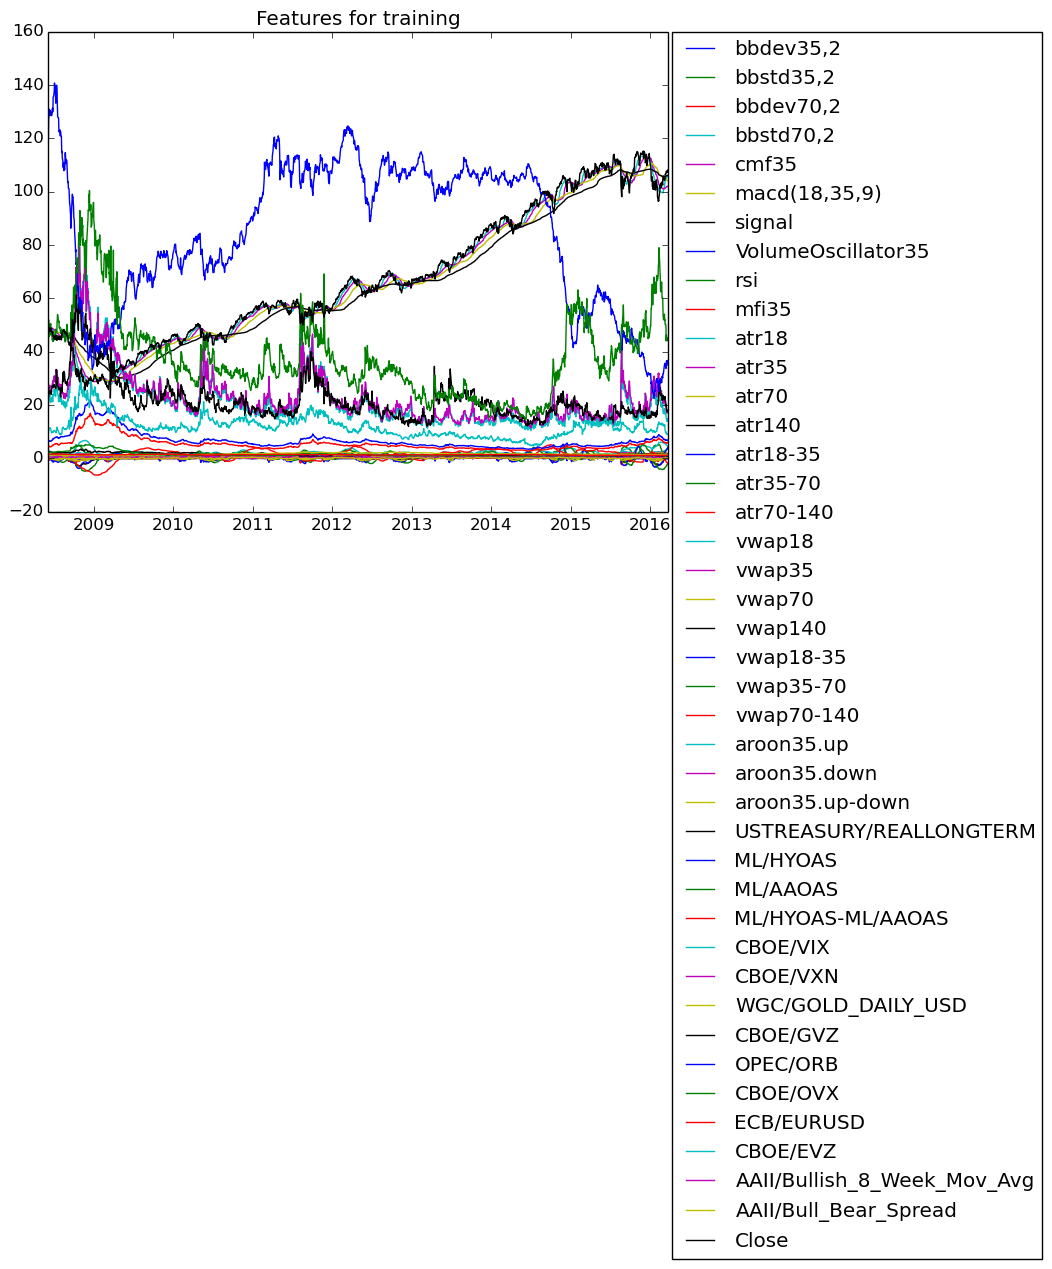

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [170]:
plot(withlabel.timestamp,withlabel.values[:,1:closeidx])
legend(withlabel.colnames[1:closeidx],bbox_to_anchor=(1.62, 1.02))
title("Features for training")

In [171]:
using DecisionTree
ntrees=100
features=training.values[:,1:closeidx]
labels=convert(Array{Float64,1},training.values[:,pricerangeidx])
# train regression forest, using 2 random features, 10 trees,
# averaging of 5 samples per leaf (optional), 0.7 of samples per tree (optional)
model = build_forest(labels, features, randomfeaturenum, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 417.45
Avg Depth:  27.24

In [172]:
newlabels=apply_forest(model, newfeatures.values);
initvalue=withlabel.values[1,closeidx];

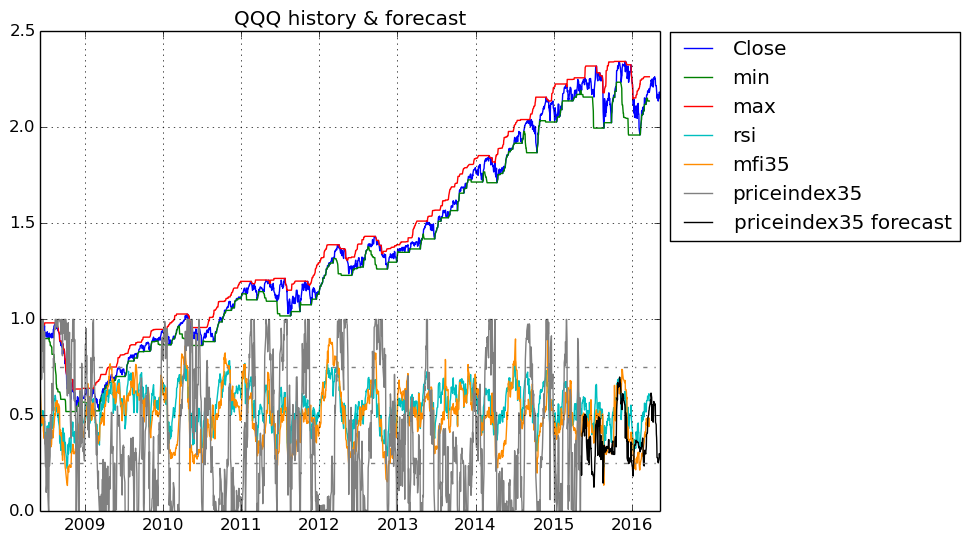

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [173]:
plot(withoutlabel.timestamp,withoutlabel.values[:,closeidx]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,closeidx+1:closeidx+2]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,rsiidx],c="c")
plot(withlabel.timestamp,withlabel.values[:,mfiidx],c="DarkOrange")
plot(training.timestamp,training.values[:,pricerangeidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
title("$symbol history & forecast")
grid("on")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")
legend([withlabel.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,pricerangeidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))

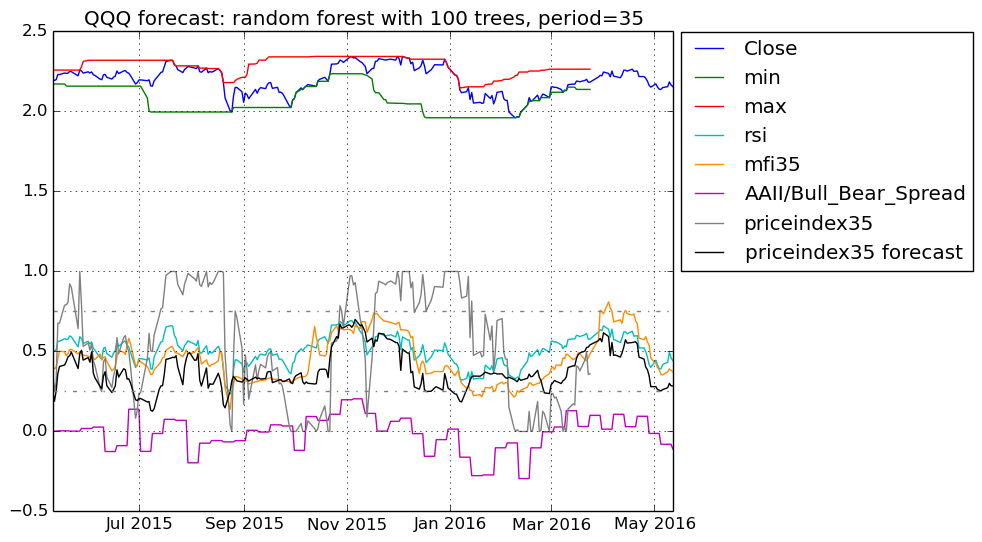

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [174]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue)
plot(test.timestamp,test.values[:,closeidx+1:closeidx+2]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,rsiidx],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,mfiidx],c="DarkOrange")
plot(newfeatures.timestamp,newfeatures.values[:,bbsidx],c="m")
plot(test.timestamp,test.values[:,pricerangeidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
legend([test.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,bbsidx,pricerangeidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))
title("$symbol forecast: random forest with $ntrees trees, period=$rangelength")
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.axhline
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")

In [175]:
features=withlabel.values[:,1:closeidx]
labels=convert(Array{Float64,1},withlabel.values[:,pricerangeidx])
# run n-fold cross validation on regression forest
# using 2 random features, 10 trees, 3 folds, averaging of 5 samples/leaf (optional),
# and 0.7 porition of samples per tree (optional)
# returns array of coefficients of determination (R^2)
r2 = nfoldCV_forest(labels, features, 2, ntrees, 3, 5, 0.7)


Fold 1
Mean Squared Error:     0.019545264521570745
Correlation Coeff:      0.9391989851134593
Coeff of Determination: 0.8233274496128109

Fold 2
Mean Squared Error:     0.02301269541322581
Correlation Coeff:      0.9259347699046222
Coeff of Determination: 0.7957838522855553

Fold 3

3-element Array{Float64,1}:
 0.823327
 0.795784
 0.816859


Mean Squared Error:     0.02094293477844972
Correlation Coeff:      0.9378631920786522
Coeff of Determination: 0.8168585782977511

Mean Coeff of Determination: 0.8119899600653723
